In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm

In [2]:
def gaussian(x, mean, sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))

def posterior_array(log_freq_percept, n_tones, p_back, p_low, 
                    log_prior_low, log_prior_high):
    """
    Arguments: 
    log_freq_percept - range of all possible frequencies (percepts?)
    p_back - prob of background, p_low - prob of low condition
    log_prior_low - gaussian of low condition
    log_prior_high - gaussian of high condition
    """
    
    log_prior_low_mean = log_prior_low[0]; log_prior_low_sigma = log_prior_low[1];
    log_prior_high_mean = log_prior_high[0]; log_prior_high_sigma = log_prior_high[1];
    prior_low = gaussian(x=log_freq_percept, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=log_freq_percept, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_high \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_low \
    #mixture model with p(T|B) = 1/no. of possible freqs
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)
    
    if n_tones == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 
    elif n_tones == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
        
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer
    # posterior /= np.sum(posterior)
    
    return prior_dist_mixed_high, prior_dist_mixed_low, posterior

In [3]:
# experimental task
def task(freq_seq, n_trials = 10, n_tones = 3, p_low = 0.5, p_back = 0.2):
    log_freq_seq_limits = [np.log10(freq_seq[0]), np.log10(freq_seq[-1])]
    log_freq_seq_mid = np.mean(log_freq_seq_limits)
    log_freq_low = [log_freq_seq_mid - 0.2,0.1]  #low freq condition is gaussian with sigma 0.1
    log_freq_high = [log_freq_seq_mid + 0.2,0.1] #high freq condition is gaussian with sigma 0.1
    trial_tones = []
    
    for trial in range(n_trials):
        signal_rand = np.random.random()
        low_dist = signal_rand < p_low #choosing true tone from either low or high condition
        tones = []
        for n_tone in range(n_tones):
            signal_back = np.random.random()
            background = signal_back < p_back #choosing background or true tone
            if background:
                tone = float(np.random.uniform(log_freq_seq_limits[0], \
                                                    log_freq_seq_limits[1], size = 1)) \
                #background freq is chosen from a uniform distribution that spans from 1-30 Hz.
                nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - 10**tone))]
            else: 
                if low_dist:
                    tone = min(max(np.random.randn()*log_freq_low[1] + log_freq_low[0],\
                                   log_freq_seq_limits[0]),log_freq_seq_limits[1])
                    nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - 10**tone))]
                else:
                    tone = min(max(np.random.randn()*log_freq_high[1] + log_freq_high[0],\
                                   log_freq_seq_limits[0]),log_freq_seq_limits[1])
                    nearest_tone = freq_seq[np.argmin(np.abs(freq_seq - 10**tone))]
            tones.append(nearest_tone)
        trial_tones.append(tones)
    return trial_tones, log_freq_low, log_freq_high

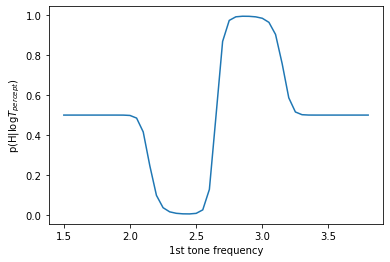

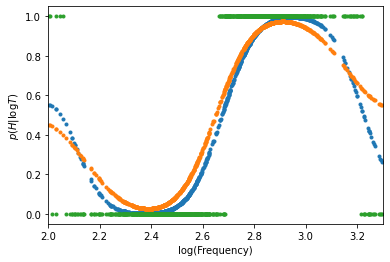

In [11]:
# Given only one true tone

# Tones from a sample experiment
expt_tones = np.arange(100,2000,1) #array of possible true tones
trial_tones, log_freq_low, log_freq_high = task(freq_seq = expt_tones, n_trials = 1000, n_tones = 1)

log_freq_percept = np.arange(np.log10(expt_tones[0])-0.5, \
                             np.log10(expt_tones[-1])+0.5, 0.05) # array of possible perceptual tones

prior_dist_mixed_high, prior_dist_mixed_low, posterior = \
posterior_array(log_freq_percept, n_tones=1, p_back=0.2, p_low=0.5, \
               log_prior_low=log_freq_low, log_prior_high=log_freq_high)
            
plt.plot(log_freq_percept,posterior)
plt.xlabel('1st tone frequency')
plt.ylabel('p(H|$\log T_{percept}$)')
plt.show() 

"""
Given the true tones, derive the noisy perceptual distribution and compute the correponding observer's behaviour
Decision rule - the behaviour is 1 if p(H|log(T_{perc})) > 0.52 and 0 if p(H|log(T_{perc})) < 0.48. 
Otherwise we assume that the observer being imperfect has a 0.5 probability of choosing high or low. 
Probability_high - probability the observer will choose high given the true tone, p(B_H|log(T))
"""
probability_bhigh = np.zeros((len(trial_tones),1))
probability_high = np.zeros((len(trial_tones),1))
behaviour = (posterior >= 0.52)
for i_post in range(len(posterior)):
    if posterior[i_post] < 0.52 and posterior[i_post] > 0.48:
        behaviour[i_post] = np.random.random() < 0.5
        
for i_stim in range(len(trial_tones)):
    input_array = gaussian(log_freq_percept, mean = np.log10(trial_tones[i_stim]), sigma = 0.1)
    input_array /= np.sum(input_array)
    input_array = np.expand_dims(input_array, axis = 1)  
    """
    for i_post in range(len(posterior)):
        if posterior[i_post] < 0.53 and posterior[i_post] > 0.47:
            behaviour[i_post] = np.random.random() < 0.5
    """        
    probability_bhigh[i_stim] = np.transpose(behaviour)@input_array
    probability_high[i_stim] = np.transpose(posterior)@input_array
    #plt.plot(log_freq_percept, input_array)
    #plt.plot(log_freq_percept, behaviour, '.')
    #plt.show()
    #pdb.set_trace()
plt.plot(np.log10(trial_tones), probability_bhigh,'.') 
plt.plot(np.log10(trial_tones), probability_high,'.')
# plt.xlim(log_freq_percept[0], log_freq_percept[-1])
plt.xlim(np.log10(expt_tones[0]),np.log10(expt_tones[-1]))
plt.ylabel('$p(H|\log T)$')
plt.xlabel('log(Frequency)')

"""
For sample experiment, we choose the observer's behaviour based on p(B_H|\log T).
If p(B_H|\log T) > 0.55, H = 1, if less than < 0.45, H = 0. Else it is a coin toss. 
"""

trial_behaviour = probability_bhigh > 0.55
for i_prob in range(len(probability_bhigh)):
        if probability_bhigh[i_prob] > 0.45 and probability_bhigh[i_prob] < 0.55:
            trial_behaviour[i_prob] = np.random.random() < 0.5
plt.plot(np.log10(trial_tones), trial_behaviour, '.')


Text(0.5, 0, 'Frequency')

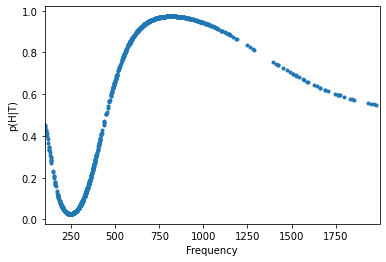

In [12]:
plt.plot(trial_tones, probability_high,'.') 
plt.xlim(expt_tones[0], expt_tones[-1])
plt.ylabel('p(H|T)')
plt.xlabel('Frequency')

In [6]:
# Given a cloud of three tones

# Tones from a sample experiment
expt_tones = np.arange(100,2000,1) #array of possible true tones
trial_tones, log_freq_low, log_freq_high = task(freq_seq = expt_tones, n_trials = 1000, n_tones = 3)

log_freq_percept = np.arange(np.log10(expt_tones[0])-0.5, \
                             np.log10(expt_tones[-1])+0.5, 0.05) # array of possible perceptual tones

prior_dist_mixed_high, prior_dist_mixed_low, posterior = \
posterior_array(log_freq_percept, n_tones=3, p_back=0.2, p_low=0.5, \
                log_prior_low=log_freq_low, log_prior_high=log_freq_high) 

"""
Given the true tones, derive the noisy perceptual distribution and compute the correponding observer's behaviour
Decision rule - the behaviour is 1 if p(H|log T_{perc}) > 0.52 and 0 if p(H|log T_{perc}) < 0.48. 
Otherwise we assume that the observer being imperfect has a 0.5 probability of choosing high or low. 
Probability_high - probability the observer will choose high given the true tone, p(B_H|T)
"""
probability_high = np.zeros((len(trial_tones),1))
behaviour = posterior >= 0.52
for i_post0 in range(posterior.shape[0]):
    for i_post1 in range(posterior.shape[1]):
        for i_post2 in range(posterior.shape[2]):
            if posterior[i_post0, i_post1, i_post2] < 0.52 and posterior[i_post0, i_post1, i_post2] > 0.48:
                behaviour[i_post0, i_post1, i_post2] = np.random.random() < 0.5
for i_stim in range(len(trial_tones)):
    input_array_0 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_stim][0]), \
                                            sigma = 0.1), axis = 1)
    input_array_1 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_stim][1]), \
                                            sigma = 0.1), axis = 1)
    input_array_2 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_stim][2]), \
                                            sigma = 0.1), axis = 1)
    input_array_mat = np.expand_dims(input_array_0@np.transpose(input_array_1),axis=2)@np.transpose(input_array_2)\
                                   #p(T1,T2..|H)     
    input_array_mat /= np.sum(input_array_mat)
    probability_high[i_stim] = np.sum(np.multiply(behaviour, input_array_mat))
    # print(trial_tones[i_trial], probability_high[i_trial])

"""
For sample experiment, we choose the observer's behaviour based on p(B_H|T).
If p(B_H|T) > 0.55, H = 1, if less than < 0.45, H = 0. Else it is a coin toss. 
"""
trial_behaviour =  probability_high > 0.55
for i_prob in range(len(probability_high)):
    if probability_high[i_prob] > 0.45 and probability_high[i_prob] < 0.55:
        trial_behaviour[i_prob] = np.random.random() < 0.5
print(np.concatenate((np.log10(trial_tones), trial_behaviour.astype(int)), axis = 1)[0:100,:]) 

[[2.96614173 2.8488047  2.71011737 1.        ]
 [2.38738983 2.47275645 2.45178644 0.        ]
 [2.33041377 2.29666519 2.90200289 0.        ]
 [2.94001816 2.86864444 2.49276039 1.        ]
 [2.86687781 2.86510397 2.95036485 1.        ]
 [2.84135947 2.29446623 2.43616265 0.        ]
 [2.8488047  2.88252454 2.80071708 1.        ]
 [2.58433122 2.83186977 2.86923172 1.        ]
 [2.55388303 2.43933269 2.56348109 0.        ]
 [3.07298474 2.84447718 2.30749604 1.        ]
 [2.80685803 2.01703334 3.00902574 1.        ]
 [2.68304704 2.74350976 2.58092498 1.        ]
 [2.66558099 2.90902085 2.88479536 1.        ]
 [3.0094509  2.40312052 2.49276039 0.        ]
 [2.9740509  2.41161971 2.48429984 0.        ]
 [2.36548798 2.24303805 2.5276299  0.        ]
 [3.22401481 2.07554696 2.82930377 1.        ]
 [2.96425963 2.87966921 3.00860017 1.        ]
 [2.40654018 2.47712125 2.45331834 0.        ]
 [2.60205999 2.24551267 2.50379068 0.        ]
 [2.2278867  2.1903317  2.31175386 0.        ]
 [2.54406804 

In [13]:
# define mle function
def MLE(params):
    log_prior_low_mean, log_prior_low_sigma, log_prior_high_mean, log_prior_high_sigma, p_back = \
    params[0], params[1], params[2], params[3], params[4] # inputs are guesses at our parameters
    
    prior_low = gaussian(x=log_freq_percept, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    prior_high = gaussian(x=log_freq_percept, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    prior_dist_mixed_high = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_high #mixture model
    prior_dist_mixed_high /= prior_dist_mixed_high.sum() #normalizing
    prior_dist_mixed_high = np.expand_dims(prior_dist_mixed_high, axis = 1)
    prior_dist_mixed_low = p_back*(1/len(log_freq_percept)) + (1-p_back)*prior_low #mixture model
    prior_dist_mixed_low /= prior_dist_mixed_low.sum() #normalizing
    prior_dist_mixed_low = np.expand_dims(prior_dist_mixed_low, axis = 1)

    if len(trial_tones[0]) == 3:
        prior_tones_low = np.expand_dims(prior_dist_mixed_low@np.transpose\
                                         (prior_dist_mixed_low),axis=2)@np.transpose(prior_dist_mixed_low) \
        #p(T1,T2..|L) 
        prior_tones_high = np.expand_dims(prior_dist_mixed_high@np.transpose\
                                          (prior_dist_mixed_high),axis=2)@np.transpose(prior_dist_mixed_high) \
        #p(T1,T2..|H) 
    elif len(trial_tones[0]) == 1:
        prior_tones_low = prior_dist_mixed_low
        prior_tones_high = prior_dist_mixed_high
    
    p_low = 0.5 
    normalizer = (1-p_low)*prior_tones_high + p_low*prior_tones_low #p(H)*p(T1,T2..|H) + p(L)*p(T1,T2..|L)
    posterior = prior_tones_high*(1-p_low)/normalizer  
    behaviour0 = posterior >= 0.52
    if len(trial_tones[0]) == 3:
        for i_post0 in range(posterior.shape[0]):
            for i_post1 in range(posterior.shape[1]):
                for i_post2 in range(posterior.shape[2]):
                    if posterior[i_post0, i_post1, i_post2] < 0.52 and posterior[i_post0, i_post1, i_post2] > 0.48:
                        behaviour0[i_post0, i_post1, i_post2] = np.random.random() < 0.5    
    elif len(trial_tones[0]) == 1:           
        for i_post in range(len(posterior)):
            if posterior[i_post] < 0.52 and posterior[i_post] > 0.48:
                behaviour0[i_post] = np.random.random() < 0.5
        
    neg_ll = 0; 
    probability_high = np.zeros((len(trial_tones),1))
    for i_trial in range(len(trial_tones)):
        if len(trial_tones[i_trial]) == 3: 
            input_array_0 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_trial][0]), \
                                            sigma = 0.1), axis = 1)
            input_array_1 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_trial][1]), \
                                            sigma = 0.1), axis = 1)
            input_array_2 = np.expand_dims(gaussian(log_freq_percept, mean = np.log10(trial_tones[i_trial][2]), \
                                            sigma = 0.1), axis = 1)
            input_array_mat = np.expand_dims(input_array_0@np.transpose\
                                             (input_array_1),axis=2)@np.transpose(input_array_2) #p(T1,T2..|H)     
            input_array_mat /= np.sum(input_array_mat)
            probability_high0 = np.sum(np.multiply(behaviour0, input_array_mat))
        elif len(trial_tones[i_trial]) == 1:
            # for i_post in range(len(posterior)):
            #     if posterior[i_post] < 0.52 and posterior[i_post] > 0.48:
            #         behaviour0[i_post] = np.random.random() < 0.5
            input_array = gaussian(log_freq_percept, mean = np.log10(trial_tones[i_trial][0]), sigma = 0.1)
            input_array /= np.sum(input_array)
            input_array = np.expand_dims(input_array, axis = 1)            
            probability_high0 = np.transpose(posterior)@input_array # np.transpose(behaviour0)@input_array
            probability_high[i_trial] = np.transpose(posterior)@input_array \
            # np.transpose(behaviour0)@input_array       
            
        if trial_behaviour[i_trial]:
            neg_ll += -np.log(probability_high0 + np.finfo(float).eps) # if high dist is chosen by observer
        else:
            neg_ll += -np.log(1 - probability_high0 + np.finfo(float).eps) # if low dist is chosen by observer
    # pdb.set_trace()        
    return(neg_ll)

In [14]:
guess_low_mean = np.arange(2.2,2.6,0.05); guess_low_sigma = np.arange(0.05,0.2,0.05)
guess_high_mean = np.arange(2.8,3.2,0.05); guess_high_sigma = np.arange(0.05,0.2,0.05)
guess_p_back = np.arange(0,1,0.05)

# constraining guesses of means of low and high distributions based on observed behaviour in figure shown above. Currently estimating only means and p_back.

neg_ll_array = np.zeros((len(guess_low_mean),len(guess_low_sigma),\
                         len(guess_high_mean),len(guess_high_sigma),len(guess_p_back)))
for lm in tqdm(range(len(guess_low_mean))):
    for ls in tqdm(range(len(guess_low_sigma)), leave=False, desc="Low sigma"):
        for hm in range(len(guess_high_mean)):
            for hs in range(len(guess_high_sigma)):
                for pb in range(len(guess_p_back)):
                    params = [guess_low_mean[lm], guess_low_sigma[ls], guess_high_mean[hm], \
                              guess_high_sigma[hs], guess_p_back[pb]]
                    # print(lm, hm, pb)
                    neg_ll_array[lm,ls,hm,hs,pb] = MLE(params)              


/home/janaki/miniconda3/envs/uncertainty/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in log


In [15]:
log_freq_low, log_freq_high

([2.450406397059058, 0.1], [2.8504063970590585, 0.1])

In [17]:
# Means and p_back corresponding to the least negative log likelihood value
idxs = np.where(neg_ll_array == np.amin(neg_ll_array)) 
guess_low_mean[idxs[0]], guess_low_sigma[idxs[1]],  guess_high_mean[idxs[2]], \
guess_high_sigma[idxs[3]], guess_p_back[idxs[4]]

(array([2.4]), array([0.1]), array([2.9]), array([0.1]), array([0.05]))

In [ ]:
# Across 5 runs the values of means and p_back are: 
# original : (array([10.]), array([14.]), array([0.4])
# 1. (array([9]), array([15]), array([0.3]))
# 2. (array([9.]), array([15.]), array([0.35])
# 3. (array([9.]), array([15.]), array([0.45])
# 4. (array([9.]), array([15.]), array([0.3]))

# original : (array([10.]), array([1]), array([14.]), array([1]), array([0.4])
# 1. (array([11.]), array([1.5]), array([13.]), array([1.5]), array([0.7]))
# 2. (array([11.]), array([1.5]), array([13.]), array([1.5]), array([0.3]))
# 3. (array([10.]), array([1.5]), array([14.]), array([1.5]), array([0.9]))
 
"""
original : (array([13.]), array([2]), array([17.]), array([2]), array([0.2])
The ranges tested for means were incorrect. 

1.(array([11.5]), array([2.]), array([16.5]), array([2.]), array([0.1]))
2. (array([11.5]), array([2.]), array([16.5]), array([2.]), array([0.25]))
3. (array([11.5]), array([2.]), array([16.5]), array([2.]), array([0.4]))
4. (array([11.5]), array([2.]), array([16.5]), array([2.]), array([0.45]))
5. (array([11.5]), array([2.]), array([16.5]), array([2.]), array([0.2]))
6. (array([11.5]), array([2.]), array([16.5]), array([2.]), array([0.2]))


# (array([11.5]), array([2.]), array([16.5]), array([2.]), array([0.5]))
# (array([11.5]), array([2.]), array([16.5]), array([2.]), array([0.7]))
# (array([11.5]), array([2.]), array([16.5]), array([2.]), array([0.3]))
# (array([11.5]), array([2.]), array([16.5]), array([2.]), array([0.3]))
"""

# (array([10.]), array([2.]), array([19.5]), array([2.]), array([0.75]))

In [ ]:
# Comparing the original posterior and that obtained by model fit parameters
# original posterior
freq_input = np.arange(1,15,0.1)
posterior = np.zeros((len(freq_input), 1))

for tone1 in range(len(freq_input)):
    prior_dist_mixed_high, prior_dist_mixed_low, posterior[tone1] = posterior_array(freq_input, tones_idx = [tone1], p_back = 0.4, p_low = 0.5)

plt.plot(freq_input,posterior)
plt.xlabel('1st tone frequency')
plt.ylabel('Probability of choosing high condition')

# posterior with parameter fit
for tone1 in range(len(freq_input)):
    prior_dist_mixed_high, prior_dist_mixed_low, posterior[tone1] = posterior_array(freq_input, tones_idx = [tone1], 
                                                                                    p_back = guess_p_back[idxs[2]], p_low = 0.5,
                                                                                    prior_low_mean = guess_low_mean[idxs[0]], prior_low_sigma = 1,
                                                                                    prior_high_mean = guess_high_mean[idxs[1]], prior_high_sigma = 1)

plt.plot(freq_input,posterior)
plt.xlabel('1st tone frequency')
plt.ylabel('Probability of choosing high condition')
plt.legend(['Original','using fitting parameters'])

In [ ]:
# p_back = 0.2 given two tones
freq_input = np.arange(1,10,0.1)
posterior = np.zeros((len(freq_input), len(freq_input)))

for tone1 in range(len(freq_input)):
    for tone2 in range(len(freq_input)):
        prior_dist_mixed_high, prior_dist_mixed_low, posterior[tone1,tone2] = posterior_array(freq_input, tones_idx = [tone1,tone2], p_back = 0.2, p_low = 0.5)

fig = plt.figure()
ax = fig.add_subplot(111)
colormap = ax.imshow(posterior, extent=[freq_input[0], freq_input[-1], freq_input[-1], freq_input[0]])
ax.invert_yaxis()
cbar = plt.colorbar(colormap, ax=ax)
ax.set_xlabel('1st tone frequency')
ax.set_ylabel('2nd tone frequency')

In [ ]:
# p_back = 0 given two tones
freq_input = np.arange(1,10,0.1)
posterior = np.zeros((len(freq_input), len(freq_input)))

for tone1 in range(len(freq_input)):
    for tone2 in range(len(freq_input)):
        prior_dist_mixed_high, prior_dist_mixed_low, posterior[tone1,tone2] = posterior_array(freq_input, tones_idx = [tone1,tone2], p_back = 0, p_low = 0.5)

fig = plt.figure()
ax = fig.add_subplot(111)
colormap = ax.imshow(posterior, extent=[freq_input[0], freq_input[-1], freq_input[-1], freq_input[0]])
ax.invert_yaxis()
cbar = plt.colorbar(colormap, ax=ax)
ax.set_xlabel('1st tone frequency')
ax.set_ylabel('2nd tone frequency')


In [ ]:
# when p_back = 0, vertical slice of colormap ii when 1st tone is 7 Hz
plt.plot(freq_input,posterior[60,:])
plt.xlabel('1st tone frequency')
plt.ylabel('Probability of high choice')

In [ ]:
# p_back = 0, n_tones = 3
freq_input = np.arange(1,10,0.1)
posterior = np.zeros((len(freq_input), len(freq_input), len(freq_input)))

for tone1 in range(len(freq_input)):
    for tone2 in range(len(freq_input)):
        for tone3 in range(len(freq_input)):
            prior_dist_mixed_high, prior_dist_mixed_low, posterior[tone1,tone2,tone3] = posterior_array(freq_input, tones_idx = [tone1,tone2,tone3], p_back = 0, p_low = 0.5)


In [ ]:
# when p_back = 0, slice of colormap iii when both 1st and 2nd tone are 7 Hz
plt.plot(freq_input,posterior[60,60,:])
plt.xlabel('3rd tone frequency')
plt.ylabel('Probability of high choice')